In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
DATA_DIR = '../../datasets/'

df = pd.read_csv(f'{DATA_DIR}tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'age_group'])
df.sample(5)

,text,age_group,tokenized
46723,WOO HOO!!! The new St.Anger CD is HELLA FUCKIN...,25-34,woo hoo ! ! ! the new st. anger cd is hella fu...
156024,I'M GOING TO DISNEY WORLD! The famous line is ...,18-24,i'm going to disney world ! the famous line is...
121655,we aren't unique...but favoritism on the part ...,>35,we are n't unique ... but favoritism on the pa...
419851,"Gods, I hate being sick! From Sunday the 25th ...",<18,"gods , i hate being sick ! from sunday the 25t..."
318769,"... judge the country by an AOL ""Current Event...",>35,"... judge the country by an aol "" current even..."


In [3]:
df['age_group'].value_counts(dropna=False)

<18      218124
25-34    195382
18-24    142348
>35       79745
Name: age_group, dtype: int64

In [4]:
df_ = df.copy()

In [5]:
df_ = df_.groupby('age_group').sample(25000, random_state=97)
df_.groupby('age_group').count()

,text,tokenized
age_group,,
18-24,25000,25000
25-34,25000,25000
<18,25000,25000
>35,25000,25000


In [6]:
enc = LabelEncoder()
enc.fit(df_['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['age_group'] = enc.transform(df_['age_group'])
encoded_labels

{'18-24': 0, '25-34': 1, '<18': 2, '>35': 3}

In [7]:
X = df_['text']
y = df_['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000,), (20000,), (80000,), (20000,))

In [8]:
vect = TfidfVectorizer()
svm = LinearSVC()

pipe = make_pipeline(vect, svm)

In [9]:
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1)],
    'linearsvc__random_state': [97],
}

In [10]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'linearsvc__random_state': 97, 'tfidfvectorizer__ngram_range': (1, 1)}


In [11]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.40      0.41      4987
           1       0.42      0.37      0.39      5021
           2       0.67      0.73      0.70      4949
           3       0.53      0.58      0.55      5043

    accuracy                           0.52     20000
   macro avg       0.51      0.52      0.51     20000
weighted avg       0.51      0.52      0.51     20000



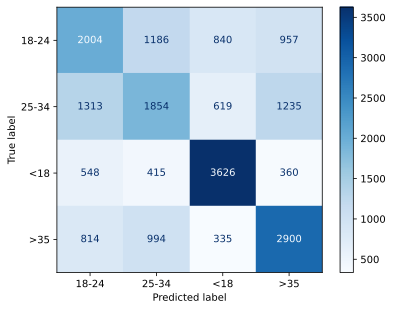

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [13]:
import joblib

joblib.dump(gs, 'age_baseline.joblib')

['age_baseline.joblib']

## Test the model

In [14]:
model = joblib.load('age_baseline.joblib')

def predict_age(text):
    classes = encoded_labels
    classes = {v: k for k, v in classes.items()} # reverse the dict
    return classes[model.predict([text])[0]]

In [15]:
predict_age("Thanks to the best teams ever for making it possible!") # Male -> Correct

'18-24'

In [16]:
predict_age("First time I got involved in a challenge was on 31-12-16 I took me almost 3 years, but I completed all the challenges") # Female -> Wrong

'>35'

In [17]:
predict_age("GM, and have a beautiful week everyone!") # Female -> Correct

'<18'

In [18]:
predict_age("I welcome the opportunity to meet the EU fishing sector in person and answer their questions about our EU Implementing Act on vulnerable marine ecosystems today.") # Male -> Correct

'>35'

## Add *n*-gram features

In [19]:
from tempfile import mkdtemp
from shutil import rmtree

In [20]:
cache_dir = mkdtemp()

pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('clf', LinearSVC(random_state=97))
    ],
    memory=cache_dir
)

In [21]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__analyzer': ['word', 'char'],
}

In [22]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\pipeline.py:336: UserWarning: Persisting input arguments took 17.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


{'vect__analyzer': 'word', 'vect__ngram_range': (1, 2)}


In [23]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.39      0.42      4987
           1       0.43      0.37      0.39      5021
           2       0.67      0.75      0.71      4949
           3       0.55      0.62      0.58      5043

    accuracy                           0.53     20000
   macro avg       0.52      0.53      0.52     20000
weighted avg       0.52      0.53      0.52     20000



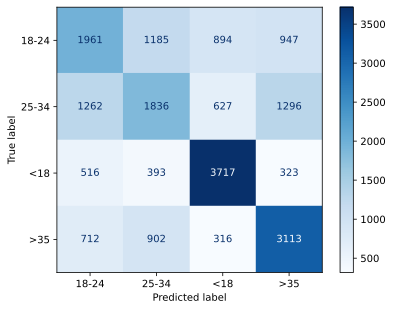

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [25]:
import joblib

joblib.dump(gs, 'age_ngram.joblib')

['age_ngram.joblib']

In [26]:
rmtree(cache_dir)

### Add PoS and punctuation features

In [27]:
DATA_DIR = '../../datasets/tokenized'

df = pd.read_csv(f'{DATA_DIR}/blog_authorship_tokenized_pos_punct_final.csv')
df.sample(5)

,text,gender,horoscope,job,age_group,tokenized,pos,total_punct,punct_dist,count_punct
104759,MAGNANIMITY This is Continuation of my earlier...,male,Virgo,Student,25-34,magnanimity this is continuation of my earlier...,PROPN DET AUX NOUN ADP PRON ADJ NOUN PUNCT PRO...,17,0.016983,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
453046,"Well it does if this is posted Joker ===== ""Co...",male,Capricorn,Government,18-24,well it does if this is posted joker = = = = =...,INTJ PRON AUX SCONJ DET AUX VERB PROPN PROPN N...,50,0.173010,"{'!': 2, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
632687,"Feeling pretty crappy, still... shouldn't a co...",male,Libra,Arts,18-24,"feeling pretty crappy , still ... should n't a...",VERB ADV ADJ PUNCT ADV PUNCT AUX PART DET ADJ ...,29,0.048414,"{'!': 1, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
339210,sent via my phone while in a meeting Just a q...,male,Libra,Communications-Media,25-34,sent via my phone while in a meeting just a ...,SPACE VERB ADP PRON NOUN SCONJ ADP DET NOUN AD...,35,0.059625,"{'!': 4, '""': 4, '#': 0, '$': 0, '%': 0, '&': ..."
2998,i just found out that D is getting married in ...,female,Aquarius,indUnk,18-24,i just found out that d is getting married in ...,PRON ADV VERB ADP SCONJ PROPN AUX VERB VERB AD...,45,0.031337,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."


In [28]:
df_ = df.drop(['horoscope', 'job', 'gender', 'tokenized'], axis=1)
df_ = df_.groupby('age_group').sample(25000)
df_.sample(5)

,text,age_group,pos,total_punct,punct_dist,count_punct
1429,Good day turned bad turned good. Thats the way...,<18,ADJ NOUN VERB ADJ VERB ADJ PUNCT DET VERB DET ...,30,0.052632,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
558720,You may think I'm a bit weird but I've never p...,25-34,PRON AUX VERB PRON AUX DET NOUN ADJ CCONJ PRON...,110,0.049909,"{'!': 0, '""': 0, '#': 0, '$': 2, '%': 0, '&': ..."
626294,My good friend Holly called me from Melbourne ...,18-24,PRON ADJ NOUN PROPN VERB PRON ADP PROPN ADJ NO...,40,0.027082,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
562614,Recent Events Shit on my end has been kinda up...,>35,ADJ NOUN INTJ ADP PRON NOUN AUX AUX ADV ADV CC...,119,0.041034,"{'!': 7, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
535375,According to a new study about the life of chu...,>35,VERB ADP DET ADJ NOUN ADP DET NOUN ADP NOUN AD...,44,0.045314,"{'!': 0, '""': 4, '#': 0, '$': 0, '%': 0, '&': ..."


In [29]:
df_['age_group'].value_counts(dropna=False)

18-24    25000
25-34    25000
<18      25000
>35      25000
Name: age_group, dtype: int64

In [30]:
enc = LabelEncoder()
enc.fit(df_['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['age_group'] = enc.transform(df_['age_group'])
encoded_labels

{'18-24': 0, '25-34': 1, '<18': 2, '>35': 3}

In [31]:
X = df_.drop('age_group', axis=1)
y = df_['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 5), (20000, 5), (80000,), (20000,))

In [32]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class RowIterator(TransformerMixin):
    """ Prepare Series for DictVectorizer """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from ast import literal_eval
        return X.apply(literal_eval)

In [33]:
from sklearn.pipeline import make_pipeline

word_pipe = Pipeline([
    ('selector', ItemSelector(key='text')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos')),
    ('vect', TfidfVectorizer(analyzer='word'))
])
   
num_pipe = Pipeline([
    ('selector', ItemSelector(key=['total_punct', 'punct_dist']))
])

punct_pipe = Pipeline([
    ('selector', ItemSelector(key='count_punct')),
    ('iter', RowIterator()),
    ('vect', DictVectorizer())
])

pipe = Pipeline([
    ('feats', FeatureUnion([  
            ('word', word_pipe),
            ('pos', pos_pipe),
            ('num', num_pipe),
            ('punct', punct_pipe)
        ],
    )),
    ('clf', LinearSVC(random_state=97, class_weight='balanced'))
])

In [34]:
param_grid = {
    'feats__word__vect__ngram_range': [(1, 2), (1, 3)],
    'feats__pos__vect__ngram_range': [(1, 2), (1, 3)],
    'clf__C': [10**x for x in range(-2, 2)],
}

In [35]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)
 
gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'clf__C': 1, 'feats__pos__vect__ngram_range': (1, 2), 'feats__word__vect__ngram_range': (1, 3)}


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.12      0.19      4987
           1       0.46      0.10      0.16      5021
           2       0.71      0.47      0.57      4949
           3       0.32      0.89      0.47      5043

    accuracy                           0.40     20000
   macro avg       0.47      0.40      0.35     20000
weighted avg       0.47      0.40      0.35     20000



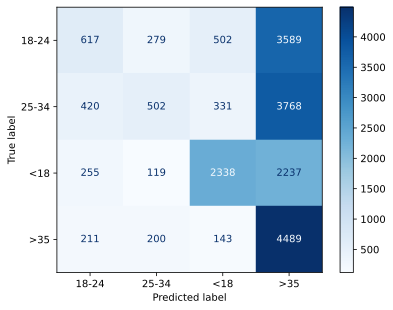

In [37]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [38]:
import joblib

joblib.dump(gs, 'age_punct.joblib')

['age_punct.joblib']

In [39]:
# from tempfile import mkdtemp
# from shutil import rmtree

# cache_dir = mkdtemp()
# rmtree(cache_dir)

## LIWC features

In [40]:
from __future__ import division
from __future__ import print_function

import re

from codecs import open
from collections import Counter


class DictFeaturizer(object):
    def __init__(self, dictionary, relative=True):
        self.dict = {}
        self.rel = relative
        matcher = re.compile(r'([\*\+])')

        for key, words in dictionary.items():

            normal = {x for x in words if not matcher.findall(x)}
            regexstring = "|".join([matcher.sub(r'\\w\1', x)
                                    for x in words if x not in normal])

            if regexstring:
                wildcards = re.compile(regexstring)
            else:
                wildcards = None

            self.dict[key] = (normal, wildcards)

    def transform(self, tokens):
        # Make frequency dictionary of the text to diminish number
        # of runs in further for loop
        freq_dict = Counter(tokens)
        features = dict()

        for key, wordlists in self.dict.items():

            normal, wildcards = wordlists

            keys = set(freq_dict.keys())

            features[key] = sum([freq_dict[k] for k in normal & keys])
            if wildcards:
                features[key] += sum([freq_dict[k] for k in keys - normal
                                      if wildcards.match(k)])

        if self.rel:
            return {k: v / len(tokens) for k, v in features.items()}
        else:
            return features

    @staticmethod
    def load(path, relative=True):
        d = {}
        with open(path, "r", encoding='utf-8') as f:
            for line in f:
                line = line.lower().strip().split(",")
                key, words = line[0], set(line[1:])
                d[key] = words

        return DictFeaturizer(d, relative=relative)


In [41]:
liwc = DictFeaturizer.load("../../datasets/LIWC/LIWC_English.csv")
sample_df = df.groupby('age_group').sample(25000)

In [42]:
sample_df = sample_df.assign(liwc=sample_df['tokenized'].apply(liwc.transform))
sample_df

,text,gender,horoscope,job,age_group,tokenized,pos,total_punct,punct_dist,count_punct,liwc
496856,"Today, I woke up feeling great, rested.... As ...",female,Virgo,Education,18-24,"today , i woke up feeling great , rested .... ...",NOUN PUNCT PRON VERB ADP VERB ADJ PUNCT VERB P...,22,0.049217,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.11038961038961038, 'pronoun': 0.04..."
244766,"So, I came to Toledo this weekend. Didn't do m...",female,Cancer,Engineering,18-24,"so , i came to toledo this weekend . did n't d...",ADV PUNCT PRON VERB ADP PROPN DET NOUN PUNCT A...,75,0.039124,"{'!': 0, '""': 4, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.11430010070493454, 'pronoun': 0.05..."
581356,"Saturday December 7, 2002 OK, this is totally ...",female,Libra,indUnk,18-24,"saturday december 7 , 2002 ok , this is totall...",PROPN PROPN NUM PUNCT NUM INTJ PUNCT DET AUX A...,30,0.039526,"{'!': 1, '""': 2, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.10406091370558376, 'pronoun': 0.05..."
311881,Planning to finish this before my laptop boots...,male,Virgo,indUnk,18-24,planning to finish this before my laptop boots...,NOUN PART VERB DET ADP PRON NOUN VERB ADP PUNC...,45,0.039199,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.11382799325463744, 'pronoun': 0.06..."
590886,One of my biggest pet peeves is being told to ...,female,Scorpio,indUnk,18-24,one of my biggest pet peeves is being told to ...,NUM ADP PRON ADJ ADJ NOUN AUX AUX VERB PART VE...,102,0.047530,"{'!': 2, '""': 10, '#': 0, '$': 0, '%': 0, '&':...","{'funct': 0.11830357142857142, 'pronoun': 0.05..."
...,...,...,...,...,...,...,...,...,...,...,...
285242,My father was particularly interested in writi...,male,Cancer,Internet,>35,my father was particularly interested in writi...,PRON NOUN AUX ADV ADJ ADP VERB PUNCT PRON VERB...,48,0.020262,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.12334437086092716, 'pronoun': 0.05..."
426297,"retrograde (by deav) Rio, Jan 2004 (exposed) i...",female,Virgo,indUnk,>35,"retrograde ( by deav ) rio , jan 2004 ( expose...",PROPN PUNCT ADP PROPN PUNCT PROPN PUNCT PROPN ...,17,0.034068,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.1145631067961165, 'pronoun': 0.075..."
297468,Today we met up with the Bay Area S2k user gro...,female,Gemini,indUnk,>35,today we met up with the bay area s2k user gro...,NOUN PRON VERB ADP ADP DET PROPN PROPN PROPN N...,25,0.023652,"{'!': 1, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.10249307479224377, 'pronoun': 0.04..."
63823,"Ok- before I reply, I have to vent a little- I...",female,Scorpio,indUnk,>35,"ok- before i reply , i have to vent a little- ...",INTJ ADP PRON VERB PUNCT PRON AUX PART VERB DE...,137,0.055020,"{'!': 7, '""': 10, '#': 0, '$': 0, '%': 0, '&':...","{'funct': 0.1130030959752322, 'pronoun': 0.053..."


In [43]:
liwc_df = sample_df['liwc'].apply(pd.Series).fillna(0).add_prefix('liwc_')
sample_df = pd.concat([sample_df, liwc_df], axis=1).drop(['text', 'liwc'], axis=1)
sample_df.shape

(100000, 73)

In [44]:
sample_df['age_group'].value_counts()

18-24    25000
25-34    25000
<18      25000
>35      25000
Name: age_group, dtype: int64

In [45]:
enc = LabelEncoder()
enc.fit(sample_df['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
sample_df['age_group'] = enc.transform(sample_df['age_group'])
encoded_labels

{'18-24': 0, '25-34': 1, '<18': 2, '>35': 3}

In [46]:
X = sample_df.drop('age_group', axis=1)
y = sample_df['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 72), (20000, 72), (80000,), (20000,))

In [47]:
word_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

num_cols = ['total_punct', 'punct_dist'] + [col for col in X.columns
                                            if col.startswith('liwc_')]

num_pipe = Pipeline([
    ('selector', ItemSelector(key=num_cols)),
])

punct_pipe = Pipeline([
    ('selector', ItemSelector(key='count_punct')),
    ('iter', RowIterator()),
    ('vect', DictVectorizer())
])

pipe = Pipeline([(
        'feats', 
        FeatureUnion([  
            ('word', word_pipe),
            ('pos', pos_pipe),
            ('num', num_pipe),
            ('punct', punct_pipe)
        ],
    )),
    ('clf', LinearSVC(random_state=97, class_weight='balanced'))
])

In [48]:
param_grid = {
    'feats__word__vect__ngram_range': [(1, 2), (1, 3)],
    'feats__pos__vect__ngram_range': [(1, 2), (1, 3)],
    'clf__C': [10**x for x in range(-2, 2)],
}

In [49]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'clf__C': 0.1, 'feats__pos__vect__ngram_range': (1, 3), 'feats__word__vect__ngram_range': (1, 2)}


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [50]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.19      0.26      4987
           1       0.33      0.63      0.43      5021
           2       0.68      0.63      0.65      4949
           3       0.55      0.35      0.43      5043

    accuracy                           0.45     20000
   macro avg       0.49      0.45      0.44     20000
weighted avg       0.49      0.45      0.44     20000



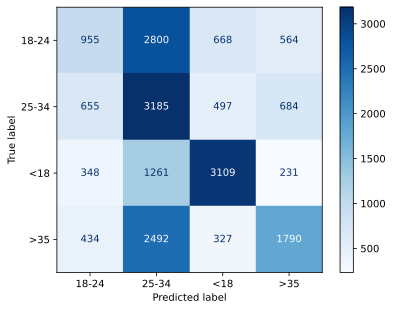

In [51]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [52]:
joblib.dump(gs, 'age_liwc.joblib')

['age_liwc.joblib']